# Starbucks offerings



This project analyses the effectiveness of Starbucks offers.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy import interpolate
% matplotlib inline

UsageError: Line magic function `%` not found.


## Understanding the business

A selected group receives offers for discounts (20% off when spending $10+), bogo (buy one, get one) or informational offers. Various offers differ in type, duration, difficulty (minimum spending) and reward (provided in discount). Also, there are some demographic data available.

The ultimate goal is to improve the provided offerings. It raises questions such as:

* Which offers are used?
* Which parameters should be changed to increase its usage or turnover?
* Can we link the perceived effects to demographic features? Thus, what offers work best for which people?

We start by analysing and cleaning the data before we do any modelling. After the modelling, we will evaluate the results and draw conclusions.

## Understanding the data

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed


In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

First, view all offers in the portfolio dataset:

## Portfolio

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


There are at least two offers for each type, and they differ in difficulty, duration and reward. The informational offers have no difficulty or reward, as might be expected since they do not involve any spendings. There is no missing data in this set.

## Profiles

Lets view the profile data.

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


There is ample of demographic information. The became_member_on does not tell much about the user. Gender and income are interesting and might affect the effects of offerings.

There are three persons with an age of exactly 118 here. These are on the records that have missing values for gender and income. So, 118 looks like an indication of a missing value. We can plot a histogram to confirm this.

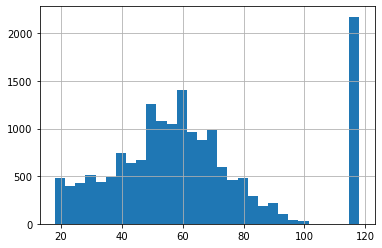

In [5]:
profile.age.hist(bins=30)

Clearly, we should treat 118 as a missing value.

There are no users with an age below around 17-18. This might be due to an age-limit, but that information was not provided.

In [6]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


We can check the distribution of the demographic features.

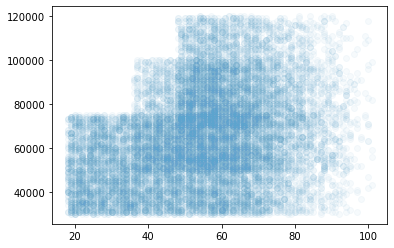

In [7]:
plt.scatter(profile.age, profile.income, alpha=0.05, color="#5ca4ce")


This plot shows three subsets of the data. The first set has an income from 0 to around 75000. The other sets have higher incomes and also have a minimum on the age. This clearly is not all data and not a random subset of all data. Therefore, we should not make conclusions about the age and income of the users. 

## Transcript

The transcript data has a type, a link to the person, a time (in hours) and a value column containing additional data.

First check which event types we have.

In [8]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

And give a sample of the value field for each event type.

In [9]:
for t in transcript.event.unique():
    print(t)
    print(transcript[transcript.event == t].value.values[0])

offer received
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
offer viewed
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
transaction
{'amount': 0.8300000000000001}
offer completed
{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}


This data is not easily accessible for analysis. We have to extract these fields and put them in separate columns.

We can plot the time of all transcripts to see if activity is evenly spread across the test period.

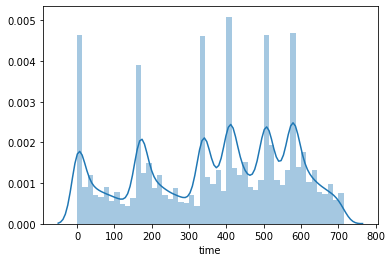

In [10]:
sns.distplot(transcript.time)

In [11]:
transcript.time.min(), transcript.time.max()

(0, 714)

The test window starts at t=0 and ends at t=714. These values are in hours. Therefore, the whole period spans 4.25 weeks. There are 6 spikes in this data that needs further investigation. We can plot the same graph with only transactions.

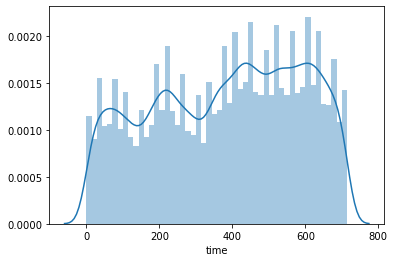

In [12]:
sns.distplot(transcript[transcript.event == 'transaction'].time)

It still has some spikes, but the 6 large spikes are not visible anymore. The spikes visible here might be due to popular hours (weekends, evenings).

For further investigation, we want to know when users got the offers. Are there specific times? And is an offer dependent on previous spendings? Or are there offers that will only be send after another offer?

This involves merging datasets.
Before doing so, we will rename the *id* columns to give them unique names across all data`sets.

In [13]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
profile.rename(columns={'id': 'profile_id'}, inplace=True)
transcript.rename(columns={'person': 'profile_id'}, inplace=True)

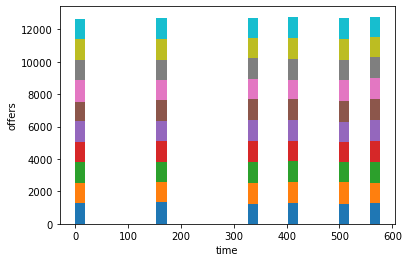

In [14]:
df = pd.merge(transcript, profile, on="profile_id")
df['offer_id'] = list(map(lambda i : i['offer id'] if ('offer id' in i) else (i['offer_id'] if ('offer_id' in i) else None), df.value.values))

x = []
for offer_id in portfolio.offer_id.values:
    x.append(df[(df.event == "offer received") & (df.offer_id == offer_id)].time.values)
plt.hist(x, bins=30, stacked=True)
plt.xlabel("time")
plt.ylabel("offers")
print("")

This graph clearly explains the observed spikes. There are 6 times that offers were sent. Each offer has more-or-less an equal share of the users. This also shows us that there are no dependencies between different offers.

We can check the exact times that offers were sent:

In [15]:
transcript[transcript.event == 'offer received'].time.value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

There are only 6 hours when offers where sent.
The number of users was slightly increased during the test period.

The first offer was sent at t=0, the second exactly 1 week later at t=168.
We can plot the transactions for the first 200 hours to see if we can observe these events in the transactions.

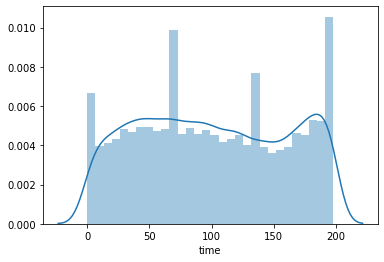

In [16]:
sns.distplot(transcript[(transcript.event == 'transaction') & (transcript.time < 200)].time)

There is a spike on t=0, but not on t=168. Therefore, these spikes should be explained by other means, such as popular hours (weekends). There is no further information to investigate.

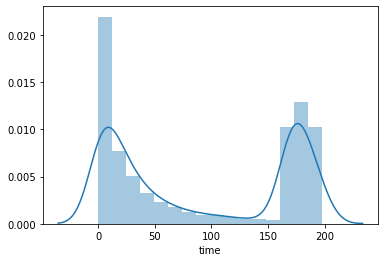

In [17]:
sns.distplot(transcript[(transcript.event == 'offer viewed') & (transcript.time < 200)].time)

The *offer viewed* events clearly follow the *offer received* events, as expected.

## Plotting events

To get an idea of the ocurring events, we want to plot all events for a single user.
This involves merging the datasets.

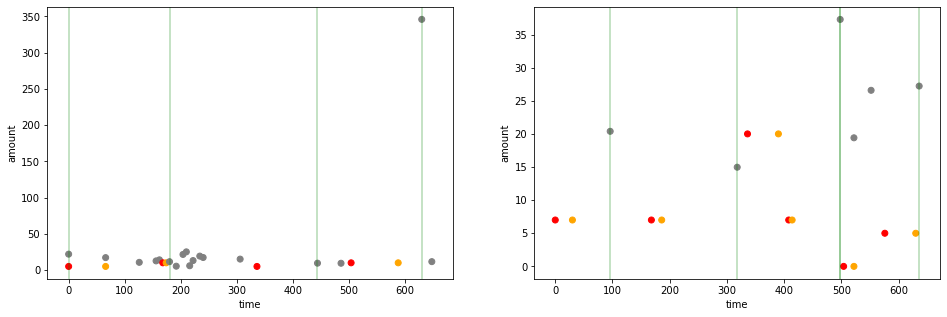

In [18]:
def plot_user(df, profile_id, show=True, figure=None):
    ax = figure if figure else plt
    rows = df[df.profile_id == profile_id]
    x = []
    y = []
    c = []
    s = []
    offer_shapes = {}
    for index, row in rows.iterrows():
        amount = 0
        color = "gray"
        shape = "."
        if row.event == "offer received":
            color = "red"
            shape = ">"
        if row.event == "offer viewed":
            color = "orange"
        if row.event == "offer completed":
            color = "green"
            ax.axvline(x=row.time, color="green", alpha=0.3)
            continue
        if 'value' in row:
            if 'amount' in row.value:
                amount = row.value['amount']
            if 'offer id' in row.value:
                amount = portfolio[portfolio.offer_id == row.value['offer id']].difficulty.values[0]
        else:
            amount = row.amount
        x.append(row.time)
        y.append(amount)
        c.append(color)
        s.append(shape)
    ax.scatter(x, y, color=c)
    if figure:
        ax.set(xlabel="time", ylabel="amount")
    else:
        ax.xlabel("time")
        ax.ylabel("amount")
    if show:
        ax.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
plot_user(transcript, "b64b461c1e4547359eb09ad574ff6f5d", False, ax1)
plot_user(transcript, "d015bf9545c1465d8328a18c8a825226", False, ax2)


The gray dots are transactions. Red, yellow and green indicate the steps in the offerings, like a stoplight. Red is an *offer received* event, orange is *offer viewed*, and the green line indicates an *offer completed* event. The green line always accompanies a transaction. The amount on the y-axis is the spent amount for transactions and the difficulty for other events. Offers with a difficulty of 0 are informational offerings.

The first graph has an outlier in the transactions. This is the transaction of around $ 350, while other transactions are 40 or lower. 350 seems to be a very high amount to spend at the register. There is no additional information available on these transactions.

## Preparation of data

Translate the age of 118 into NaN, to indicate a missing value.

In [19]:
profile['age'] = list(map(lambda i : np.nan if i == 118 else i, profile.age.values))
profile.head()

,gender,age,profile_id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Extrat the data from the value column in the transcript data.

In [20]:
# Note that 'offer id' is used in 'offer viewed' and 'offer_id' for 'offer completed' events (with underscore).
transcript['offer_id'] = list(map(lambda i : i['offer id'] if ('offer id' in i) else (i['offer_id'] if ('offer_id' in i) else None), transcript.value.values))
transcript['amount'] = list(map(lambda i : i['amount'] if ('amount' in i) else np.nan, transcript.value.values))

# Call this column 'transaction_reward' to not confuse it with column in portfolio.
transcript['transaction_reward'] = list(map(lambda i : i['reward'] if ('reward' in i) else np.nan, transcript.value.values))
transcript = transcript.drop(columns=['value'])

In [21]:
transcript.describe()

,time,amount,transaction_reward
count,306534.000000,138953.000000,33579.000000
mean,366.382940,12.777356,4.904137
std,200.326314,30.250529,2.886647
min,0.000000,0.050000,2.000000
25%,186.000000,2.780000,2.000000
50%,408.000000,8.890000,5.000000
75%,528.000000,18.070000,5.000000
max,714.000000,1062.280000,10.000000


This allows us to plot the amount.

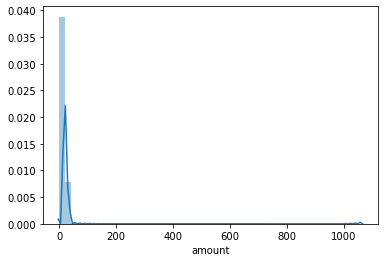

In [22]:
sns.distplot(transcript[transcript.event == 'transaction'].amount)

There are outliers, as already abserved, even above $ 1000. But there are only a very few of them.
We can also plot the transactions below 50.

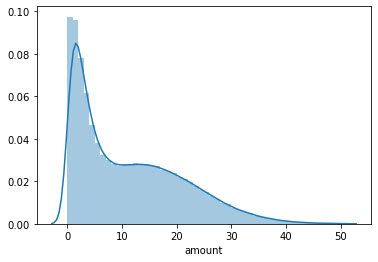

In [23]:
sns.distplot(transcript[transcript['amount'] < 50].amount)

The *channels* field in portfolio has multiple labels. We want to one-hot encode this column before we do any modelling.

In [24]:
for field in ['web', 'email', 'mobile', 'social']:
    portfolio[field] = list(map(lambda i : 1 if field in i else 0, portfolio.channels))
portfolio = portfolio.drop(columns=['channels'])

In [25]:
profile = profile.set_index('profile_id')
portfolio = portfolio.set_index('offer_id')

Split off a testset from the profile dataframe. Profiles are linked to transcript data. Therefore, this split implicitly also splits the transcripts in train and test data. We split them here instead of combining all sets first because we want to analyse the transactions per profile.

In [26]:
profile, profile_test = train_test_split(profile, test_size=0.25, random_state=42)

Build a dataframe that combines all sources. We have to do this for training and testing data. The inner join to profile makes sure that the train/test split is maintained in the new dataframes.

In [27]:
df = transcript.join(profile, on='profile_id', how='inner')
df = df.join(portfolio, on='offer_id')

df_test = transcript.join(profile_test, on='profile_id', how='inner')
df_test = df_test.join(portfolio, on='offer_id')

df.shape[0], df_test.shape[0]

(229700, 76834)

### Used offers

Normally, offers have an *offer received* event, followed by *offer viewed* and *offer completed*. There must be a transaction accompanying an *offer completed* event. However, informational offers do not get an *offer completed* event, but are completed when viewed. And it is also possible that an offer is completed without being viewed. The offer has not affected the transaction in that case, and we should not mark them as completed.

Now build an *offers_used* dataframe that only contains offers that are used, by the criteria set.

In [28]:
def get_merged_offers(df):
    offers_viewed = df[df.event == "offer viewed"]
    offers_completed = df[df.event == "offer completed"]
    return pd.merge(offers_viewed, offers_completed, on=['offer_id', 'profile_id'], how='left', sort=False, suffixes=('_viewed', '_completed')) 

In [29]:
def get_used_offers(df, filter_unused=True):
    offers_merged = get_merged_offers(df)

    offers_merged['id'] = offers_merged.index.values
    offers_with_transactions = pd.merge(offers_merged[offers_merged.offer_type_viewed == 'informational'], transcript[transcript.event == 'transaction'], on='profile_id', how='left', sort=False)

    # Filter transactions that were viewed before this offer.
    offers_with_transactions = offers_with_transactions[offers_with_transactions.time_viewed <= offers_with_transactions.time]

    times = offers_with_transactions[['id', 'time']].groupby('id').min()
    times = times.rename(columns={"time": "time_completed"})
    offers_merged = offers_merged.copy()
    offers_merged.update(times)

    offers_merged['used'] = offers_merged.time_completed >= offers_merged.time_viewed
    
    if filter_unused:
        offers_merged = offers_merged[offers_merged.used == True]

    return offers_merged.copy()

In [30]:
offers_used = get_used_offers(df)
offers_used.shape

(29116, 36)

Each offer has a duration for which it remains valid. We can check the response time by subtracting the time for the 'offer viewed' event from the time of the 'offer completed' event. It should not exceed the duration. Note that time is given in hours and duration in days.

In [31]:
offers_used['exceeds_duration'] = (offers_used.time_completed - offers_used.time_viewed) > offers_used.duration_viewed * 24
offers_used[offers_used.exceeds_duration].shape

(4986, 37)

Looks like 17% of the offer completed records are too late and thus not valid anymore. Remove these orders from the offers_used dataframe.

In [32]:
offers_used = offers_used[offers_used.exceeds_duration != True]
offers_used.shape

(24130, 37)

Now that we have a list of used offers, we can add some figures to the portfolio dataframe.

In [33]:
offers_merged = get_merged_offers(df)
portfolio['issued'] = offers_merged.offer_id.value_counts()
portfolio['used'] = offers_used.offer_id.value_counts()
portfolio['used_pct'] = portfolio.used / portfolio.issued * 100
portfolio.sort_values('used_pct', ascending=False)

,reward,difficulty,duration,offer_type,web,email,mobile,social,issued,used,used_pct
offer_id,,,,,,,,,,,
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,1,0,3119,2053,65.822379
5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,0,1,1,1,4984,3183,63.864366
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1,1,1,1,6729,3843,57.111012
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1,1,1,1,6672,3471,52.023381
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1,1,0,0,2356,1118,47.453311
2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,1,1,1,0,3687,1710,46.379170
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0,3708,1681,45.334412
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,6428,2778,43.217175
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,0,1,1,1,5863,2139,36.483029


This gives us a first impression on which offers are popular, in terms of how likely it is that they get completed.

## Modelling

We want to know the increase in turnover, per offering and related to demographic features.
To measure the increase, we need a baseline of the turnover that is not affected by the offers. Let's check the number of persons that have never seen an offer.

In [34]:
profile_count = len(df.profile_id.unique())
profile_viewed_count = len(df[df.event == 'offer viewed'].profile_id.unique())
print(profile_count)
print(profile_count - profile_viewed_count)

12750
133


There are only 166 of them. And those persons might not be representative for all users. Hence we cannot extract the desired baseline. As a result, we can only make conclusions that are relative to other offerings ("offer A is better than B"). This is still a useful thing to do. We still can drop negative results, since we know that we can do better.

The first offer is at t = 0 and the second at t = 168. Each user got only a single offer, so all transactions before t = 168 are affected only by this offer. Transactions from t=168 are affected by multiple offers, and hence are more difficult to use for analysis.

First, we will analyse the period before t = 168. This period includes all different orders so that we can calculate the average turnover per offer. This data can then be used to calculate means per offer type, channel or gender.

Later, we will use all used offers in our analysis. We measure impact by comparing the turnover in the week before and the week after the *offer viewed* event. We will generate the same figures from this data so that we can compare the results from both methods.

The calculated increase in turnover will be used in a classification model to predict if this value is negative or positive. We will do this for all used offers. Another model will predict if offers will be used.

### Model metrics
Both false negatives neither false positives are a big deal in this context. Therefore, recall and precision scores do not seem to fit. Also, the classes are more-or-less balanced. Hence, the accuracy score seems to fit the best for our purpose.

## Analyzing the first offer

First, create a dataframe containing the used offers in the first week.

In [35]:
profile_first_spendings = df[df.time < 168].groupby('profile_id').sum()
first_offers = offers_used[offers_used.time_viewed < 168]

first_offers = pd.merge(first_offers, profile_first_spendings, on='profile_id', suffixes=('', '_profile'))
first_offers = first_offers.drop(columns=['web', 'mobile', 'email', 'social'])
first_offers = pd.merge(first_offers, portfolio, on='offer_id', suffixes=('', '_offer'))
first_offers.head()

,profile_id,event_viewed,time_viewed,offer_id,amount_viewed,transaction_reward_viewed,gender_viewed,age_viewed,became_member_on_viewed,income_viewed,...,difficulty_offer,duration_offer,offer_type,web,email,mobile,social,issued,used_offer,used_pct
0,c27e0d6ab72c455a8bb66d980963de60,offer viewed,18,3f207df678b143eea3cee63160fa8bed,NaN,NaN,F,78.0,20170616,71000.0,...,0,4,informational,1,1,1,0,3119,2053,65.822379
1,6747dda08bed46298c23e05b64820a3a,offer viewed,12,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,71.0,20170129,57000.0,...,0,4,informational,1,1,1,0,3119,2053,65.822379
2,65f06566a2a14f64b003964f211635e1,offer viewed,48,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,25.0,20151027,68000.0,...,0,4,informational,1,1,1,0,3119,2053,65.822379
3,2c5c71b7bfaa4e3e8088fc177e6e559b,offer viewed,114,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,89.0,20150917,101000.0,...,0,4,informational,1,1,1,0,3119,2053,65.822379
4,2c3a4de659584bed8d27cfd865f06928,offer viewed,24,3f207df678b143eea3cee63160fa8bed,NaN,NaN,F,30.0,20171015,40000.0,...,0,4,informational,1,1,1,0,3119,2053,65.822379


Add the average turnover in the first week to the *portfolio* dataframe.

In [36]:
portfolio['first_offer_turnover'] = 0
for index, row in first_offers.groupby('offer_id').mean()[['amount']].iterrows():
    portfolio.loc[index, 'first_offer_turnover'] = row.amount
portfolio.sort_values('first_offer_turnover', ascending=False)[['first_offer_turnover']]

,first_offer_turnover
offer_id,
ae264e3637204a6fb9bb56bc8210ddfd,54.032887
4d5c57ea9a6940dd891ad53e9dbe8da0,52.496122
fafdcd668e3743c1bb461111dcafc2a4,49.759284
f19421c1d4aa40978ebb69ca19b0e20d,46.832470
2906b810c7d4411798c6938adc9daaa5,46.096893
2298d6c36e964ae4a3e7e9706d1fb8c2,42.954124
0b1e1539f2cc45b7b9fa7c272da2e1d7,39.304236
9b98b8c7a33c4b65b9aebfe6a799e6d9,36.830081
3f207df678b143eea3cee63160fa8bed,26.276062


This gives us a first insight of the turnover per offer. We can also group this by offer type.

In [37]:
first_offers.groupby('offer_type').mean().amount

offer_type
bogo             48.136277
discount         45.777314
informational    25.067037
Name: amount, dtype: float64

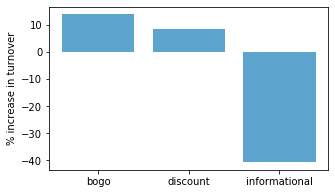

In [38]:
def plot_spending_by_type(df, ax=plt, show=True):
    avg_spending = df.amount.mean()
    types = ['bogo', 'discount', 'informational']
    performance = []
    for t in types:
        type_spending = df[df.offer_type == t].amount.mean()
        performance.append((type_spending - avg_spending) / avg_spending * 100)

    y_pos = np.arange(len(types))
    ax.bar(y_pos, performance, align="center", color="#5ca4ce")
    if show:
        ax.xticks(y_pos, types)
        ax.ylabel('% increase in turnover')
        ax.show()

plt.figure(figsize=(5, 3))
plot_spending_by_type(first_offers)

And grouped by channel:

In [39]:
first_offers.groupby(['web', 'email', 'mobile', 'social']).mean().amount

web  email  mobile  social
0    1      1       1         36.683445
1    1      0       0         39.304236
            1       0         35.849624
                    1         47.710087
Name: amount, dtype: float64

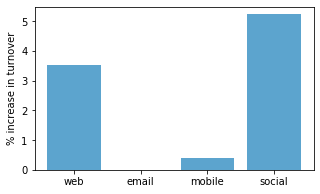

In [40]:
def plot_spending_by_medium(df, ax=plt, show=True):
    avg_spending = df.amount.mean()
    media = ['web', 'email', 'mobile', 'social']
    performance = []
    for medium in media:
        medium_spending = df.groupby(medium).mean().amount[1]
        performance.append((medium_spending - avg_spending) / avg_spending * 100)

    y_pos = np.arange(len(media))
    ax.bar(y_pos, performance, align="center", color="#5ca4ce")
    if show:
        ax.xticks(y_pos, media)
        ax.ylabel('% increase in turnover')
        ax.show()

plt.figure(figsize=(5, 3))
plot_spending_by_medium(first_offers)

There is no data for email, which is because there were no offers that were not sent via email. Therefore it is impossible to measure its impact.

There are three demographic features: gender, age and income. We can visualize differences in the former by generating two charts, for both genders. We cannot use this method directly for age or income, therefore we will check the correlations later.

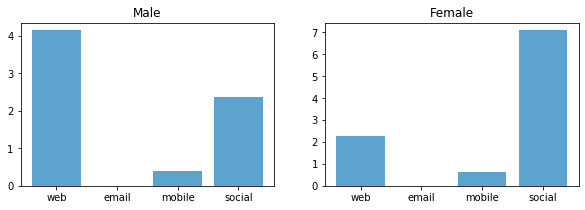

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.set_title("Male")
plot_spending_by_medium(first_offers[first_offers.gender_viewed == "M"], ax1, False)
ax2.set_title("Female")
plot_spending_by_medium(first_offers[first_offers.gender_viewed == "F"], ax2, False)
plt.setp((ax1, ax2), xticks=[0,1,2,3], xticklabels=["web", "email", "mobile", "social"])
plt.show()

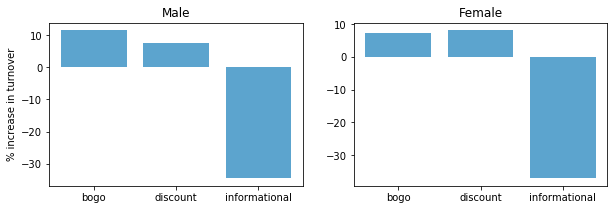

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.set_title("Male")
plot_spending_by_type(first_offers[first_offers.gender_viewed == "M"], ax1, False)
ax2.set_title("Female")
plot_spending_by_type(first_offers[first_offers.gender_viewed == "F"], ax2, False)
ax1.set(ylabel="% increase in turnover")
plt.setp((ax1, ax2), xticks=[0,1,2], xticklabels=["bogo", "discount", "informational"])
plt.show()

And check correlation for effect of age and income.

[Text(0.5, 0, 'time_viewed'),
 Text(1.5, 0, 'difficulty_viewed'),
 Text(2.5, 0, 'reward_viewed'),
 Text(3.5, 0, 'mobile'),
 Text(4.5, 0, 'web'),
 Text(5.5, 0, 'social'),
 Text(6.5, 0, 'age_completed'),
 Text(7.5, 0, 'income_completed'),
 Text(8.5, 0, 'duration_completed'),
 Text(9.5, 0, 'amount')]

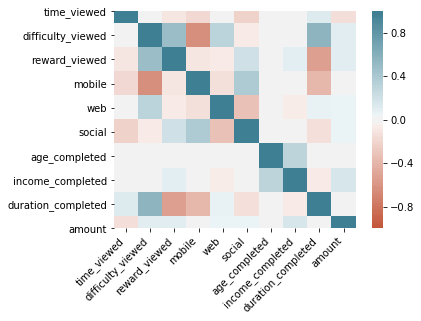

In [43]:
# Note that email is not in the list. Every discount was sent via email.
corr = first_offers[[
    'time_viewed',
    'difficulty_viewed',
    'reward_viewed',
    'mobile',
    'web',
    'social',
    'age_completed',
    'income_completed',
    'duration_completed',
    'amount'
]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

The difficulty, reward and mobile are related negatively to duration. But this comes solely from the offers and has nothing to do with the user data. We are interested in relations with amount or relationships between media and age or income. There are no significant correlations with age or income.

## Turnover predictions

The first actual modelling we want to do is predicting the turnover change for a given offer.

We want to convert the transactions into revenue over a fixed period. A week is a convenient period for this kind of data since it is not affected by increased revenues during the weekends. So we can safely compare different weeks to see if there is any effect.

The transaction data spans over 714 hours, which is four weeks and 42 hours. We can always start our period on the hour 0, but we want to align it with the time of a given transaction. Therefore, we only have three full weeks if we start after the 42nd hour in any week.

We start by building a method to translate transaction data into weekly revenue.

In [44]:
def weekly_revenue(df, profile_id, from_time=0, to_time=714):
    X = []
    y = []
    df_person = df[df.profile_id == profile_id]
    df_person = df_person[df_person.event == "transaction"]
    duration = to_time - from_time
    weeks = int(duration / 168)
    for i in range(0, weeks):
        df_period = df_person[df_person.time >= from_time + 168 * i]
        df_period = df_period[df_period.time <= from_time + 168 * i + 168]
        # Set the X to the middle of the week.
        X.append([from_time + 168 * i + 168 / 2])
        y.append(df_period.amount.sum())
    return X, y

weekly_revenue(df, "d015bf9545c1465d8328a18c8a825226", from_time=10)

([[94.0], [262.0], [430.0], [598.0]], [20.39, 14.97, 37.28, 73.21])

In order to model the turnover, we want to model a curve that fits the weekly revenue. Given the number of weeks, there are only 3 of 4 datapoints. This is too little to generate a smooth higher degree curve. Therefore, we use a linear function. However, we use BSpline to cut this into two segments, one before the *order viewed* event and one after.

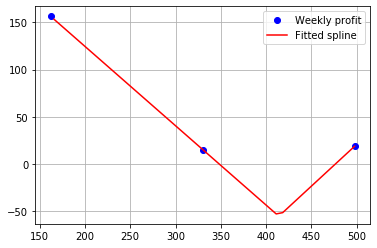

In [45]:
def fit_revenue_spline(df, profile_id, event_time):
    x, y = weekly_revenue(df, profile_id, from_time=event_time % 168)
    t, c, k = interpolate.splrep(x, y, k=1, t=[event_time])
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    return spline

profile_id = "b64b461c1e4547359eb09ad574ff6f5d"

x, y = weekly_revenue(df, profile_id, from_time=414 % 168)
plt.plot(x, y, 'bo', label="Weekly profit")

spline = fit_revenue_spline(df, profile_id, 414)
curve = np.linspace(0, 714, 100)
plt.plot(curve, spline(curve), 'r', label="Fitted spline")
plt.grid()
plt.legend()
plt.show()

We can integrate the week before the event and the week after to get the turnover for both weeks. The turnover in the week after minus the turnover in the week before is the increase in turnover due to the event.

In [46]:
def revenue_increase(df, profile_id, event_time, term=1):
    spline = fit_revenue_spline(df, profile_id, event_time)
    before = spline.integrate(event_time - 168, event_time) / 168
    after = spline.integrate(event_time + (term - 1) * 168, event_time + term * 168) / 168
    return after - before

revenue_increase(df, profile_id, 414)

-24.297500000000014

This number is the added revenue from the week after the event compared with the week before. We use an absolute number here to overcome division by zero errors.

In [47]:
offers_usable = offers_used[(offers_used.time_viewed > 168) & (offers_used.time_completed < 714 - 168)]
offers_usable.shape[0]

12595

Build a method to check the revenue increase for a given offer.

In [48]:
def check_offer(offer, term=1):
    time = int(offer.time_viewed)
    return revenue_increase(df, offer.profile_id, time, term)

offer_id = offers_usable[offers_usable.time_viewed < 714 - 168].index.values[0]
check_offer(offers_usable.loc[offer_id], 1), check_offer(offers_usable.loc[offer_id], 2)

(-19.963749999999997, -39.31)

In [49]:
def get_offers_viewed_before(offer):
    time = int(offer.time_viewed)
    return df[(df.profile_id == offer.profile_id) & (df.time < time) & (df.event == 'offer viewed')].shape[0]

offer_id = offers_usable[offers_usable.time_viewed < 714 - 168].index.values[0]
get_offers_viewed_before(offers_usable.loc[offer_id])

1

Apply these methods to all offers in the *offers_usable* dataframe.

In [50]:
offers_usable['average_turnover'] = np.nan
count = 0
sample_size = offers_usable.shape[0]

# This might take a while. For testing, use a smaller sample size:
# sample_size = 123

for index, row in offers_usable.sample(n=sample_size, random_state=42).iterrows():
    offers_usable.loc[index, 'average_turnover'] = check_offer(offers_usable.loc[index], 1)
    offers_usable.loc[index, 'offers_viewed_before'] = get_offers_viewed_before(offers_usable.loc[index])
    count += 1
    if count % 500 == 0:
        print(count)

offers_usable.average_turnover.mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500


4.419015978562923

In [51]:
pickle.dump(offers_usable, open('offers.p', 'wb'))

In [52]:
# Resume from here after breaking above analysis.
offers_usable = pickle.load(open('offers.p', 'rb'))

The average of these results can be added to the *portfolio* dataframe.

In [53]:
portfolio['turnover'] = offers_usable.groupby('offer_id').mean().average_turnover

# Convert to Z-values
portfolio['turnover'] = (portfolio.turnover - portfolio.turnover.mean()) / portfolio.turnover.std()

portfolio.sort_values(by='turnover', ascending=False)

,reward,difficulty,duration,offer_type,web,email,mobile,social,issued,used,used_pct,first_offer_turnover,turnover
offer_id,,,,,,,,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1,1,0,0,2356,1118,47.453311,39.304236,1.993397
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,0,1,1,1,5863,2139,36.483029,54.032887,0.879830
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1,1,1,1,6729,3843,57.111012,49.759284,0.520584
2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,1,1,1,0,3687,1710,46.379170,46.096893,0.302052
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0,3708,1681,45.334412,36.830081,0.016428
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1,1,6128,2154,35.150131,52.496122,-0.275299
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,6428,2778,43.217175,46.832470,-0.342454
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1,1,1,1,6672,3471,52.023381,42.954124,-0.456256
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,1,0,3119,2053,65.822379,26.276062,-1.254877


This gives us a first insight on what offers increase turnover the most.

We can also group this by offer type.

In [54]:
portfolio.groupby('offer_type').mean()

,reward,difficulty,duration,web,email,mobile,social,issued,used,used_pct,first_offer_turnover,turnover
offer_type,,,,,,,,,,,,
bogo,7.5,7.50,6.0,0.75,1.0,1.00,0.75,5531.75,2188.0,40.046187,47.547890,0.069626
discount,3.0,11.75,8.5,1.00,1.0,0.75,0.50,4861.00,2535.5,50.741719,44.528634,0.589944
informational,0.0,0.00,3.5,0.50,1.0,1.00,0.50,4051.50,2618.0,64.843372,25.251749,-1.319140


And check correlations with our new figures.

In [55]:
corr = portfolio[['difficulty', 'duration', 'reward', 'web', 'mobile', 'social', 'turnover']].corr()
corr[['turnover']]

,turnover
difficulty,0.939576
duration,0.865173
reward,0.454458
web,0.132704
mobile,-0.700408
social,-0.227430
turnover,1.000000


And plot regression with reward and difficulty.

[Text(0, 0.5, 'Turnover (Z-score)')]

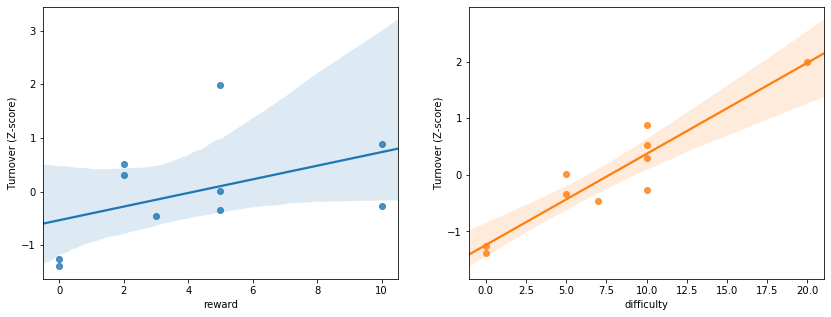

In [56]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(x="reward", y="turnover", data=portfolio, ax=ax1);
ax1.set(ylabel="Turnover (Z-score)")

sns.regplot(x="difficulty", y="turnover", data=portfolio, ax=ax2);
ax2.set(ylabel="Turnover (Z-score)")

These plots suggest that increasing reward and difficulty results in higher turnover. But both figures are related to bigger spendings, which are included in the short term turnover. Therefore, this correlation is expected for the short-term. This spending is not included in the long-term however. It looks like high rewards and difficulty results in increased turnover in the long term.

Plot the turnover by offer type and channel. Both total and separated by gender.

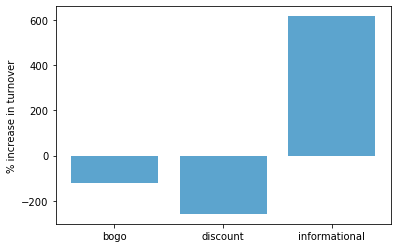

In [57]:
data = pd.merge(offers_usable, portfolio, on="offer_id")
data = data[data.turnover.isna() == False]
data = data.rename(columns={"turnover": "amount"})
plot_spending_by_type(data)

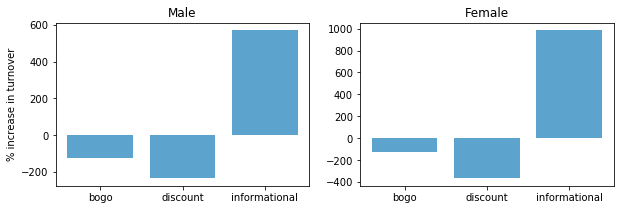

In [58]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.set_title("Male")
plot_spending_by_type(data[data.gender_viewed == "M"], ax1, False)
ax2.set_title("Female")
plot_spending_by_type(data[data.gender_viewed == "F"], ax2, False)
ax1.set(ylabel="% increase in turnover")
plt.setp((ax1, ax2), xticks=[0,1,2], xticklabels=["bogo", "discount", "informational"])
plt.show()

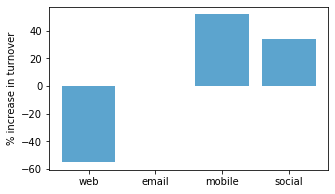

In [59]:
plt.figure(figsize=(5, 3))
plot_spending_by_medium(data)

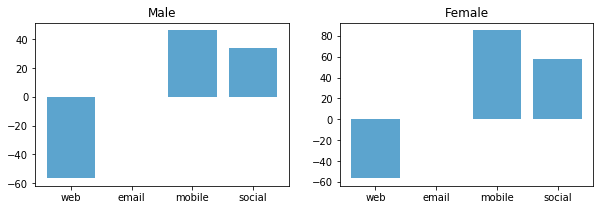

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.set_title("Male")
plot_spending_by_medium(data[data.gender_viewed == "M"], ax1, False)
ax2.set_title("Female")
plot_spending_by_medium(data[data.gender_viewed == "F"], ax2, False)
plt.setp((ax1, ax2), xticks=[0,1,2,3], xticklabels=["web", "email", "mobile", "social"])
plt.show()

## Classification
Use the relative turnover to build a classification to predict whether this turnover is above or below the average. In other words: predict if the offer is doing well.

In [61]:
# Get the records that we have predictions for. This should be all records,
# but for testing, we sometimes only have caulcations for a sample.
selection = offers_usable[offers_usable.average_turnover.isna() == False]

# Select relevant columns and rename them to prevent long column names.
selection = selection[[
    'age_viewed',
    'gender_viewed',
    'offer_type_viewed',
    'reward_viewed',
    'duration_viewed',
    'difficulty_viewed',
    'web_viewed',
    'email_viewed',
    'mobile_viewed',
    'social_viewed',
    'average_turnover',
    'offers_viewed_before'
]].rename(columns={
    'age_viewed': 'age',
    'gender_viewed': 'gender',
    'offer_type_viewed': 'type',
    'reward_viewed': 'reward',
    'duration_viewed': 'duration',
    'difficulty_viewed': 'difficulty',
    'web_viewed': 'web',
    'email_viewed': 'email',
    'mobile_viewed': 'mobile',
    'social_viewed': 'social',
    'average_turnover': 'turnover'
})

# One-hot encode gender and offer type.
selection = pd.get_dummies(selection, columns=['gender', 'type'])

# Use imputer to fill NA's.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_imp = pd.DataFrame(imp.fit_transform(selection))
df_imp.columns = selection.columns
df_imp.index = selection.index
selection = df_imp

# Scale values.
scaler = StandardScaler()
selection_scaled = pd.DataFrame(scaler.fit_transform(selection))
selection_scaled.columns = selection.columns
selection_scaled.index = selection.index

# Translate turnover to binary class.
selection['turnover'] = list(map(lambda v : 1 if v > 0 else 0, selection.turnover.values))
# Copy to scaled df. There is no need to scale this column.
selection_scaled['turnover'] = selection.turnover.values

# Split into train and test data.
selection_scaled, selection_scaled_test = train_test_split(selection_scaled, test_size=0.25, random_state=42)

# Separate X and y columns.
def get_x_features(df):
    return df[[
        'age',
        'gender_M', 'gender_F', 'gender_O',
        'type_bogo', 'type_discount', 'type_informational',
        'reward',
        'duration',
        'difficulty',
        'web',
        'email',
        'mobile',
        'social',
        'offers_viewed_before'
    ]]
X = get_x_features(selection_scaled)
y = selection_scaled.turnover
X_test = get_x_features(selection_scaled_test)
y_test = selection_scaled_test.turnover

In [62]:
models = {
    'randomforest': RandomForestClassifier(),
    'ada': AdaBoostClassifier(),
    'bagging': BaggingClassifier(),
    'gradientboosting': GradientBoostingClassifier(),
    'decisiontree': DecisionTreeClassifier(),
    'logistic': LogisticRegression(),
    'ridge': RidgeClassifier(),
    'sgd': SGDClassifier()
}

for model in models:
    models[model].fit(X, y)
    y_pred = models[model].predict(X_test)
    print("{}: {}".format(model, accuracy_score(y_test, y_pred)))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


randomforest: 0.6560812956494125
ada: 0.7189583994919022
bagging: 0.6478247062559542
gradientboosting: 0.7145125436646554
decisiontree: 0.637980311209908


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logistic: 0.7192759606224198
ridge: 0.7176881549698317
sgd: 0.7103842489679263


The decision tree works best on this dataset. Tune it with GridSearchCV.

In [63]:
selection, selection_test = train_test_split(selection, test_size=0.25, random_state=42)
X = get_x_features(selection)
y = selection.turnover
X_test = get_x_features(selection)
y_test = selection.turnover

In [64]:
def grid_search_tree(X, y):
    model = DecisionTreeClassifier(random_state=42)
    parameters = {
        'max_depth': [5, 10, 15, 30, 50],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [1, 2, 3],
        'criterion': ['gini', 'entropy']
    }
    scorer = make_scorer(accuracy_score)
    grid = GridSearchCV(model, parameters, scoring=scorer, cv=5)
    grid.fit(X, y)
    return grid

grid = grid_search_tree(X, y)
model = grid.best_estimator_
accuracy_score(y_test, model.predict(X_test)), grid.best_params_

(0.72146940503917,
 {'criterion': 'entropy',
  'max_depth': 5,
  'min_samples_leaf': 2,
  'min_samples_split': 2})

In [65]:
export_graphviz(model, out_file='tree.dot', filled=True, rounded=True, special_characters=False, impurity=False, feature_names=X.columns)

The graph is pretty clear about the key result: if the user already had seen two or more offers before, the increase in turnover is likely to be below average. In other words: the first two offers are effective. Subsequent offers are not. At least not in the timespan of 4 weeks.

## Predicting if an offer will be used

Until now, we have only analysed offers that have been used.
Here, we build a linear model to predict if an offer will be used.

In [66]:
selection = get_used_offers(df, False)

# Select relevant columns and rename them to prevent long column names.
selection = selection[[
    'age_viewed',
    'gender_viewed',
    'offer_type_viewed',
    'reward_viewed',
    'duration_viewed',
    'difficulty_viewed',
    'web_viewed',
    'email_viewed',
    'mobile_viewed',
    'social_viewed',
    'used'
]].rename(columns={
    'age_viewed': 'age',
    'gender_viewed': 'gender',
    'offer_type_viewed': 'type',
    'reward_viewed': 'reward',
    'duration_viewed': 'duration',
    'difficulty_viewed': 'difficulty',
    'web_viewed': 'web',
    'email_viewed': 'email',
    'mobile_viewed': 'mobile',
    'social_viewed': 'social'
})

# One-hot encode gender and offer type.
selection = pd.get_dummies(selection, columns=['gender', 'type'])

# Use imputer to fill NA's.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_imp = pd.DataFrame(imp.fit_transform(selection))
df_imp.columns = selection.columns
df_imp.index = selection.index
selection = df_imp

# Split into train and test data.
selection, selection_test = train_test_split(selection, test_size=0.25, random_state=42)

# Separate X and y columns.
X = selection[[
    'age',
    'gender_M', 'gender_F', 'gender_O',
    'type_bogo', 'type_discount', 'type_informational',
    'reward',
    'duration',
    'difficulty',
    'web',
    'email',
    'mobile',
    'social'
]]
y = selection.used
X_test = selection_test[[
    'age',
    'gender_M', 'gender_F', 'gender_O',
    'type_bogo', 'type_discount', 'type_informational',
    'reward',
    'duration',
    'difficulty',
    'web',
    'email',
    'mobile',
    'social'
]]
y_test = selection_test.used

grid = grid_search_tree(X, y)
model = grid.best_estimator_
accuracy_score(y_test, model.predict(X_test)), grid.best_params_

(0.677349222964812,
 {'criterion': 'gini',
  'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 2})

In [67]:
export_graphviz(model, out_file='used.dot', filled=True, rounded=True, special_characters=False, impurity=False, feature_names=X.columns)

In general, informational offers will be used by most of the people, regardless of demographic features. Gender plays an important role for other offer types. Females use them in 62% and males in 47% of the cases. Females prefer discounts over bogo's (66% versus 
59%). For males, the reward counts. Offers with a reward below 7.5 are used in 59% of the cases, versus 40% for high-reward offers. It does not seem reasonable that a high reward alone is the cause for low usage. There are only two offers with a reward above this value. These are bogo's with a reward and difficulty of 10. In the distribution plot with the transaction amounts we see that most transactions are below 10, while completing this bogo requires a transaction of at least 20 dollars.

# Evaluation

We have used different methods to analyse the offers. In this section, all meaningful observations are tested against our test set, that we had split off in the preparation step.

## Discounts are used more than bogo's

In the test data, the least used discount is used more than the most used bogo. Clearly, the discounts are more popular here. Let's confirm that in the testdata.

In [68]:
used = get_used_offers(df_test).offer_type_completed.value_counts();
total = get_merged_offers(df_test).offer_type_completed.value_counts();
used / total

discount    0.780972
bogo        0.745941
Name: offer_type_completed, dtype: float64

The difference is not as big as expected, but discounts are still more popular here.
We might favor discounts over bogo's for this reason.

## When using bogo's, it's best to only provide these offers to men.

In the barcharts comparing turnover increase per offer type, we observed a difference between men and women. Men are more likely to use a bogo.

In [69]:
used = get_used_offers(df_test)
used[used.offer_type_completed == 'bogo'].gender_viewed.value_counts()

F    1633
M    1619
O      67
Name: gender_viewed, dtype: int64

This difference cannot be observed in the testset.

## Web offers are more likely to be used than mobile offers

In the analysis of the first offers, web increased the turnover more than mobile does. But this is not about its usage, but about the increase in turnover. Later, we predicted if an offer will be used. In this model, the coefficient for web is larger than for mobile, suggesting that web offers are used more than mobile offers.

In [70]:
used = get_used_offers(df_test)
total = get_merged_offers(df_test)
print(used.sum().web_viewed / total.sum().web_viewed)
print(used.sum().mobile_viewed / total.sum().mobile_viewed)

0.5711749266635788
0.5894530260825526


In the testset, mobile offers are used 59% of the time, versus 57% for web. This denies our previous finding.

## Which orders to stop and which to continue?

We have calculated some figures to show the effect of an offer. These were added to the portfolio dataframe.

In [71]:
portfolio

,reward,difficulty,duration,offer_type,web,email,mobile,social,issued,used,used_pct,first_offer_turnover,turnover
offer_id,,,,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,0,1,1,1,5863,2139,36.483029,54.032887,0.879830
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1,1,6128,2154,35.150131,52.496122,-0.275299
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,1,0,3119,2053,65.822379,26.276062,-1.254877
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0,3708,1681,45.334412,36.830081,0.016428
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1,1,0,0,2356,1118,47.453311,39.304236,1.993397
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1,1,1,1,6672,3471,52.023381,42.954124,-0.456256
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1,1,1,1,6729,3843,57.111012,49.759284,0.520584
5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,0,1,1,1,4984,3183,63.864366,24.227436,-1.383404
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,6428,2778,43.217175,46.832470,-0.342454


We can generate a rank from these figures.

In [72]:
def add_rank(df, column):
    df[column + '_rank'] = 0
    rank = 0
    for index, row in df.sort_values(column, ascending=False).iterrows():
        rank += 1
        df.loc[index, column + '_rank'] = rank

add_rank(portfolio, 'used_pct')
add_rank(portfolio, 'turnover')
add_rank(portfolio, 'first_offer_turnover')

portfolio.sort_values('used_pct_rank')[['offer_type', 'used_pct_rank', 'turnover_rank', 'first_offer_turnover_rank']]


,offer_type,used_pct_rank,turnover_rank,first_offer_turnover_rank
offer_id,,,,
3f207df678b143eea3cee63160fa8bed,informational,1,9,9
5a8bc65990b245e5a138643cd4eb9837,informational,2,10,10
fafdcd668e3743c1bb461111dcafc2a4,discount,3,3,3
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,4,8,6
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,7
2906b810c7d4411798c6938adc9daaa5,discount,6,4,5
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,8
f19421c1d4aa40978ebb69ca19b0e20d,bogo,8,7,4
ae264e3637204a6fb9bb56bc8210ddfd,bogo,9,2,1


When sorted on used percentage, it's clear that this order does not correspondent with the change in turnover.

In [79]:
portfolio.sort_values('turnover_rank')[['offer_type', 'used_pct_rank', 'turnover_rank', 'first_offer_turnover_rank']]

,offer_type,used_pct_rank,turnover_rank,first_offer_turnover_rank
offer_id,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,7
ae264e3637204a6fb9bb56bc8210ddfd,bogo,9,2,1
fafdcd668e3743c1bb461111dcafc2a4,discount,3,3,3
2906b810c7d4411798c6938adc9daaa5,discount,6,4,5
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,8
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,6,2
f19421c1d4aa40978ebb69ca19b0e20d,bogo,8,7,4
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,4,8,6
3f207df678b143eea3cee63160fa8bed,informational,1,9,9


When sorted on the turnover increase in the short-term, we also see that the long-term effect is very different for some of the offers.

We should consider to stop discount 2298..b8c2, because it seems to have a (relative) negative effect on the turnover.
Other discounts are doing much better. This might have to do with the high difficulty (7).

Note that the (relative) turnover is negative for the lowest five offers on this list. This is not suprising for informational offers. We should also reconsider the two bogo's in this range, namely 4d5c..8da0 and f194..e20d.

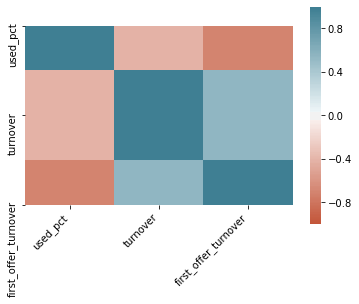

In [74]:
# Calculate correlations.
# Use spearman because we are using this data in the context of ranked lists rather than absolute values.
corr = portfolio[[
    'used_pct',
    'turnover',
    'first_offer_turnover',
]].corr(method='spearman')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The correlation between the turnover figures are positive, as expected. The used percentage has a negative correlation with other figures. This is expected, because of the greater the difficulty, the higher the turnover, but the lower the usage.

## Effect of duration

In the linear regression, the coefficient for duration is positive for usage and turnover in the short-term, but negative in the long-term. The observed difference between offers fafd..c2a4 and 2906..aaa5 also suggest that it is better to limit the duration. Should we limit offers to 7 days maximum?

In [75]:
used = get_used_offers(df_test, False)
used[used.duration_viewed < 7].used.mean(), used[used.duration_viewed > 7].used.mean()

(0.6356228172293364, 0.6001324064879179)

In [78]:
ttest_ind(used[used.duration_viewed < 7].used, used[used.duration_viewed > 7].used)

Ttest_indResult(statistic=3.3594047511629475, pvalue=0.0007840580342126527)

A quick check on the testdata shows that offers with a duration less than 7 days are used in 64% of the case, while offers with a duration more than 7 days are used only 60% of the time. The difference is statistically significant (p = 3.36, t < 0.01).

## Females prefer discounts over bogo's

This was observed in the decision tree.

In [76]:
from scipy.stats import ttest_ind

females = used[(used.gender_viewed == 'F')]
values_discount = females[females.offer_type_completed == 'discount'].used
values_bogo = females[females.offer_type_completed == 'bogo'].used

ttest_ind(values_discount, values_bogo), values_discount.mean(), values_bogo.mean()

(Ttest_indResult(statistic=1.5254004706346138, pvalue=0.12723254578873885),
 0.7629839471199245,
 0.7429481346678799)

We can verify this claim by comparing means, but this is not a significant difference according to the t-test.

## For males, avoid bogo's with rewards above 7.5

This advice might not be specific to men. However, it was observed in the decision tree for men only. We should trust the model that this fact is not important for woman and resist the urge to check this fact only on the testdata.

In [77]:
males = used[(used.gender_viewed == 'M')]
values_low_reward = males[(males.offer_type_completed == 'bogo') & (males.reward_completed <= 7.5)].used
values_high_reward = males[(males.offer_type_completed == 'bogo') & (males.reward_completed > 7.5)].used

ttest_ind(values_low_reward, values_high_reward), values_low_reward.mean(), values_high_reward.mean()

(Ttest_indResult(statistic=1.6870742174939843, pvalue=0.09173300496602874),
 0.760705289672544,
 0.7290388548057259)

Like the previous claim. Means agree with our findings, but not statistically significant.

# Conclusions

## Reflection

Starbucks wants to know what offers works best and why. An experiment was set up with three different offer types: discounts, buy-one-get-one (bogo) and informational. Each class has multiple configurations that differ in duration, reward (earnings when completing) and difficulty (minimum spending). In total, there were ten settings. The available demographic features are age, income and gender. This information has to be combined with the transaction data to gain useful insights about which offers work, and what factors account for that.

The provided data is sparse compared to many other Data Science projects. This project is also exciting since not all have a lot of data. Getting more information from a few dimensions makes this an inspiring project as well because it requires a creative and flexible approach. There are no basic modelling techniques that can handle this data directly. A custom method was needed to know if an offer was used, the change in turnover, and the number of offers seen before.

## Improvements

The model that predicts if an order was used does not include the number of offers that the user viewed before. In this analysis, this number was only calculated for used offers. We might calculate this for all offers to improve this model.

Several methods were used to analyse the effect of the offers. Each analysis has its own shortcomings. Analysis of the first offer does not use all data. The turnover calculations look at the week before and after the event, but these might overlap with other events. This effect is not corrected, but it is assumed that the average effect is not highly affected by this.

Another possibility is to create a model that a single coefficient per offer. This indicates if the turnover is negatively or positively affected by this offer. We can then create a spline that models the weekly turnover per person. We can use higher degree curves to model the decay after the offer. The coefficients can be tuned by implementing gradient descent. This is not a standard implementation (like linear regression), but it likely gives a better representation of the turnover.

## Recommendations
The test design could use some improvements:

* Include at least one offer that is not sent via e-mail. Currently, it is not possible to measure the effect of sending an offer per mail.
* Consider including a period without offers, or pick random users that do not get an offer. If we do this, we can measure the turnover for people that do not get any offer, and therefore calculate the nett increase in turnover for people that do receive offers.

The following recommendations can be made on the offers:

* Prefer discounts over bogo's. Discounts are more likely to be used.
* Favor web orders over mobile. Web orders are more likely to be used.
* Stop discount 2298..b8c2, because it seems to have a (relative) adverse effect on the turnover.
* Consider to stop bogo's 4d5c..8da0 and f194..e20d.
* Limit duration to 7 days. Offers that are valid for more than seven days tend to be used less.

There were some observations about demographic features. These are:

* Females prefer discounts over bogo's
* For males, avoid bogo's with rewards above 7.5

Both findings are not statistically significant. However, we might still implement the decision tree to determine if we should send an offer. This model includes these findings. It can predict if an offer will be used with 68% accuracy, which is better than the current (naive) model that sends an offer to everybody. Only 59% of the offers were used, which is also the accuracy of this naive model. Therefore, it seems reasonable to implement this decision tree, to avoid irritating users with offers they will not use.